## DSC Project 

In [1]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime               import date
from sklearn                import tree
from sklearn                import neighbors
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import confusion_matrix
from pandas                 import DataFrame
from pandas                 import read_csv
from pandas                 import get_dummies
from numpy                  import array
from numpy                  import random
from numpy                  import where
from numpy                  import nan
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score

In [2]:
import sys
sys.path.append("C:/Users/kamal/DESC & PRED/Predictive modeling-20211204/notebooks")
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

### Get the data 

In [3]:
donors = pd.read_csv("C:/Users/kamal/DSC GRP PRJ/donors.csv")
gifts = pd.read_csv("C:/Users/kamal/DSC GRP PRJ/gifts.csv")
campaigns = pd.read_csv("C:/Users/kamal/DSC GRP PRJ/campaigns.csv",sep = ";")

### Clean the datasets 

In [4]:
donors.head()

,Unnamed: 0,donorID,zipcode,province,region,gender,language,dateOfBirth
0,0,100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,1,100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,2,100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,3,100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,4,100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [5]:
# Dropping Unnecessary Columns
donors = donors.drop(columns = ["Unnamed: 0"])
# Verifying what columns have missing values
donors.isna().sum()

donorID         0
zipcode         2
province        0
region          0
gender         32
language        0
dateOfBirth     0
dtype: int64

In [6]:
# Dropping the rows where there are missing values 
donors = donors.drop(donors[donors['zipcode'].isna()].index)

#Encoding for Missing Values 
donors["Missing_Gender"] = where(donors["gender"].isnull(), 1, 0)
donors["gender"] = donors["gender"].replace({nan: 0})

# Integer encoding for the gender variable 
dictionary = {"M": 0, "F": 1}
donors = donors.replace({"gender": dictionary})

donors.gender = donors.gender.astype(int)
donors.zipcode = donors.zipcode.astype(int)
donors.dateOfBirth = donors.dateOfBirth.astype('datetime64[ns]')
donors.donorID = donors.donorID.astype(str)

donors['province'] = donors['province'].str.upper()
donors['region'] = donors['region'].str.upper()

# Integer encoding for the province & region variable 

dic1 = {"ANTWERP": 0, "BRUSSELS": 1,"EAST FLANDERS" : 2,  "FLEMISH BRABANT" : 3 ,  "HAINAUT" :4, "LIEGE" : 5,"LIMBURG" : 6
             ,"LUXEMBOURG" : 7,"NAMUR" : 8,"WALLOON BRABANT" :9 ,"WEST FLANDERS" : 10 }
donors = donors.replace({"province": dic1})

dic2 = {"BRUSSELS": 0, "FLANDERS": 1,"WALLONIA" : 2}
donors = donors.replace({"region": dic2})

dic3 = {"EN": 0, "NL": 1,"FR" : 2}
donors = donors.replace({"language": dic3})

del dic1
del dic2
del dic3

# Verifying that there are no more missing values
donors.isna().sum()

donorID           0
zipcode           0
province          0
region            0
gender            0
language          0
dateOfBirth       0
Missing_Gender    0
dtype: int64

In [7]:
donors.dtypes

donorID                   object
zipcode                    int32
province                   int64
region                     int64
gender                     int32
language                   int64
dateOfBirth       datetime64[ns]
Missing_Gender             int32
dtype: object

In [8]:
# Replacing DOB with Age on the day of campaigns
donors['camp1'] = '2018-09-04'
donors['camp2'] = '2019-06-18'
donors['camp3'] = '2020-02-01'

donors.camp1 = donors.camp1.astype('datetime64[ns]')
donors.camp2 = donors.camp2.astype('datetime64[ns]')
donors.camp3 = donors.camp3.astype('datetime64[ns]')

donors['camp1_age'] = (donors.camp1 - donors.dateOfBirth)/np.timedelta64(1, 'Y')
donors['camp2_age'] = (donors.camp2 - donors.dateOfBirth)/np.timedelta64(1, 'Y')
donors['camp3_age'] = (donors.camp3 - donors.dateOfBirth)/np.timedelta64(1, 'Y')

donors.camp1_age = donors.camp1_age.astype(int)
donors.camp2_age = donors.camp2_age.astype(int)
donors.camp3_age = donors.camp3_age.astype(int)

donors = donors.drop(columns=["camp1","camp2","camp3"])
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth,Missing_Gender,camp1_age,camp2_age,camp3_age
0,100001,1861,3,1,1,1,1967-12-24,0,50,51,52
1,100002,2260,0,1,0,1,1952-01-14,0,66,67,68
2,100003,1780,3,1,0,1,1986-12-23,0,31,32,33
3,100004,1020,1,0,1,2,1952-03-29,0,66,67,67
4,100005,1020,1,0,1,2,1986-06-25,0,32,32,33


In [9]:
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [10]:
# Transforming the date into a datetime format 
campaigns['date'] = pd.to_datetime(campaigns['date'])


# Verifying the type of date_of_birth 
campaigns['date'].dtype

#working on data transformation on column lettersSent 
lsent = []
for i in campaigns['lettersSent']:
    lsent.append(int(i[:-4])*1000 + int(i[-3:]))
campaigns['lettersSent'] = lsent

#changing CostUnit values to 0.8
campaigns['CostUnit'] = 0.8

campaigns.isna().sum()

campaignID     0
date           0
lettersSent    0
CostUnit       0
dtype: int64

In [11]:
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6873,0.8
1,154,2005-01-01,7656,0.8
2,180,2005-01-18,9933,0.8
3,433,2005-01-29,7448,0.8
4,476,2005-12-02,6605,0.8


In [12]:
gifts.head()

,Unnamed: 0,donorID,campaignID,amount,date
0,0,100001,NaN,"12,39",2004-03-23
1,1,100001,1577.0,"12,39",2007-10-11
2,2,100001,1634.0,"6,69",2007-12-28
3,3,100001,1778.0,"24,79",2008-06-14
4,4,100001,1808.0,"7,44",2008-07-09


In [13]:
#Defining the type of variables in the gift Table 
gifts = gifts.drop(columns = ["Unnamed: 0"])
gifts['donorID'] = gifts['donorID'].astype(str)
gifts['campaignID'] = gifts['campaignID'].astype(str).str[0:-2]
gifts.amount = gifts.amount.str.replace(",",".")
gifts.amount = gifts.amount.astype('float64')
gifts.date = gifts.date.astype('datetime64[ns]')
gifts.head()

,donorID,campaignID,amount,date
0,100001,n,12.39,2004-03-23
1,100001,1577,12.39,2007-10-11
2,100001,1634,6.69,2007-12-28
3,100001,1778,24.79,2008-06-14
4,100001,1808,7.44,2008-07-09


In [14]:
gifts[gifts['campaignID'] == 'n'] 

,donorID,campaignID,amount,date
0,100001,n,12.39,2004-03-23
29,100004,n,24.79,2006-03-30
57,100007,n,24.79,2006-09-04
112,100020,n,24.79,2001-12-05
181,100025,n,20.00,2009-05-29
...,...,...,...,...
216506,144666,n,32.25,2010-10-11
216507,144667,n,49.58,2004-02-01
216514,144668,n,20.00,2019-11-20
216560,144683,n,50.00,2015-10-11


# Creating a New Variable for Non Campaign Donations

In [15]:
gifts['NCD'] = 0
gifts.loc[gifts['campaignID'] == 'n', 'campaignID'] = 'NCD'
gifts.loc[gifts['campaignID'] == 'NCD', 'NCD'] = 1
gifts.head(100)

,donorID,campaignID,amount,date,NCD
0,100001,NCD,12.39,2004-03-23,1
1,100001,1577,12.39,2007-10-11,0
2,100001,1634,6.69,2007-12-28,0
3,100001,1778,24.79,2008-06-14,0
4,100001,1808,7.44,2008-07-09,0
...,...,...,...,...,...
95,100012,4210,5.00,2015-11-02,0
96,100013,4213,30.00,2015-12-06,0
97,100014,2414,30.00,2010-05-10,0
98,100015,3941,6.25,2015-01-01,0


In [16]:
gifts.isna().sum()

donorID       0
campaignID    0
amount        0
date          0
NCD           0
dtype: int64

In [17]:
#Subsetting the list of Donors for 6169 campaign 

ID1 = gifts[gifts['campaignID'] == '6169']
ID1.loc[:,'Donated'] = 1
ID1['Donated'] = ID1['Donated'].astype(str)
ID1.head(2000)

C:\Users\kamal\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\kamal\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-17-46de5f7f28a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,donorID,campaignID,amount,date,NCD,Donated
132,100023,6169,15.0,2018-09-15,0,1
705,100126,6169,123.0,2018-09-11,0,1
1151,100253,6169,120.0,2018-09-18,0,1
1362,100279,6169,75.0,2018-09-13,0,1
1804,100320,6169,135.0,2018-09-09,0,1
...,...,...,...,...,...,...
216589,265584,6169,300.0,2018-09-23,0,1
216590,281770,6169,30.0,2018-09-08,0,1
216591,317880,6169,157.5,2018-09-12,0,1
216592,480980,6169,36.0,2018-09-12,0,1


# Creating the First Table for the Training the Model.

In [18]:
sel_6169 = pd.read_csv("C:/Users/kamal/DSC GRP PRJ/selection campaign 6169.csv")
ftable1 = pd.DataFrame(sel_6169['donorID'].drop_duplicates())
ftable1['donorID'] = ftable1['donorID'].astype(str)
ftable1.head()

,donorID
0,100001
1,100002
2,100004
3,100008
4,100009


In [19]:
ftable1.dtypes

donorID    object
dtype: object

In [20]:
# Creating Donor ID Wise metric based on Historic Data 

M1 = gifts[gifts['date'] < '2018-08-04'].groupby(['donorID'])['amount'].sum()
M1['donorID'] = M1.index

Ma1 = gifts[gifts['date'] < '2018-08-04'].groupby(['donorID'])['amount'].max()
Ma1['donorID'] = Ma1.index

Mi1 = gifts[gifts['date'] < '2018-08-04'].groupby(['donorID'])['amount'].min()
Mi1['donorID'] = Mi1.index

F1= gifts[gifts['date'] < '2018-08-04'].groupby(['donorID'])['date'].count()
F1['donorID'] = F1.index

M2 = gifts[(gifts['date'] < '2018-08-04') & (gifts['date'] > '2015-08-04')].groupby(['donorID'])['amount'].sum()
M2['donorID'] = M2.index

F2= gifts[(gifts['date'] < '2018-08-04') & (gifts['date'] > '2015-08-04')].groupby(['donorID'])['date'].count()
F2['donorID'] = F2.index


M3 = gifts[(gifts['date'] < '2018-08-04') & (gifts['date'] > '2012-08-04')].groupby(['donorID'])['amount'].sum()
M3['donorID'] = M3.index

F3= gifts[(gifts['date'] < '2018-08-04') & (gifts['date'] > '2012-08-04')].groupby(['donorID'])['date'].count()
F3['donorID'] = F3.index


M4 = gifts[(gifts['date'] < '2018-08-04') & (gifts['date'] > '2009-08-04')].groupby(['donorID'])['amount'].sum()
M4['donorID'] = M4.index

F4= gifts[(gifts['date'] < '2018-08-04') & (gifts['date'] > '2009-08-04')].groupby(['donorID'])['date'].count()
F4['donorID'] = F4.index


NC1= gifts[gifts['date'] < '2018-08-04'].groupby(['donorID'])['NCD'].sum()
NC1['donorID'] = NC1.index

R1= gifts[gifts['date'] < '2018-08-04'].groupby(['donorID']).agg({'date': [np.min,np.max]})
R2 = R1['date']
R2['camp_date'] = '2018-09-04'
R2.camp_date = R2.camp_date.astype('datetime64[ns]')
R2['Recency'] = (R2.camp_date - R2.amax).dt.days
R2['Tenure'] = (R2.amax - R2.amin).dt.days
R2.Recency =  R2.Recency.astype('int')
R2.head()

#Merging this values from gift table for each individual ID's

ftable1 = (ftable1.merge(M1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable1 = (ftable1.merge(F1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable1 = (ftable1.merge(NC1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable1 = (ftable1.merge(R2, left_on = 'donorID', right_on = 'donorID',how = 'left'))

ftable1.drop(['amax','camp_date'],axis=1,inplace=True)

ftable1.rename(columns={'amount': 'Total Donated Amount','date':'No_Donation','NCD' : 'Non-Camp Donations', 'amount_y':'Max Donation'
                       }, inplace=True)

ftable1['Avg_donation'] = ftable1['Total Donated Amount'] / ftable1['No_Donation']
ftable1['ADGBD'] = ftable1['Tenure'] / ftable1['No_Donation']

ftable1 = (ftable1.merge(Ma1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable1 = (ftable1.merge(Mi1, left_on = 'donorID', right_on = 'donorID',how = 'left'))

ftable1.rename(columns={'amount_x': 'Max Donation','amount_y': 'Min Donation',}, inplace=True)

ftable1 = (ftable1.merge(M2, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable1 = (ftable1.merge(F2, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable1 = (ftable1.merge(M3, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable1 = (ftable1.merge(F3, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable1 = (ftable1.merge(M4, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable1 = (ftable1.merge(F4, left_on = 'donorID', right_on = 'donorID',how = 'left'))

ftable1.rename(columns={'amount_x': 'Tot_Donation_3','amount_y': 'Tot_Donation_6', 'amount': 'Tot_Donation_9'}, inplace=True)
ftable1.rename(columns={'date_x': 'Tot_FRQ_3','date_y': 'Tot_FRQ_6', 'date': 'Tot_FRQ_9'}, inplace=True)

ftable1['Avg_donation_3'] = ftable1['Tot_Donation_3'] / ftable1['Tot_FRQ_3']
ftable1['Avg_donation_6'] = ftable1['Tot_Donation_6'] / ftable1['Tot_FRQ_6']
ftable1['Avg_donation_9'] = ftable1['Tot_Donation_9'] / ftable1['Tot_FRQ_9']

ftable1['Total_donated_30'] = 0
ftable1.loc[ftable1['Total Donated Amount'] >= 30, 'Total_donated_30']  = 1


del M1
del F1
del NC1
del R1
del R2

ftable1.head(100) # ftable1 has each customers donation behaviour from before 4th August 2018.

<ipython-input-20-c336866148ac>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R2['camp_date'] = '2018-09-04'
C:\Users\kamal\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-20-c336866148ac>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,amin,Recency,Tenure,Avg_donation,ADGBD,Max Donation,...,Tot_Donation_3,Tot_FRQ_3,Tot_Donation_6,Tot_FRQ_6,Tot_Donation_9,Tot_FRQ_9,Avg_donation_3,Avg_donation_6,Avg_donation_9,Total_donated_30
0,100001,178.49,12,1,2004-03-23,2440.0,2838.0,14.874167,236.5,30.0,...,NaN,NaN,NaN,NaN,60.0,5,NaN,NaN,12.0,1
1,100002,20.0,1,0,2015-01-10,1333.0,0.0,20.0,0.0,20.0,...,NaN,NaN,20.0,1,20.0,1,NaN,20.0,20.0,0
2,100004,716.22,26,1,2005-07-02,2650.0,2162.0,27.546923,83.153846,49.58,...,NaN,NaN,NaN,NaN,180.0,6,NaN,NaN,30.0,1
3,100008,124.37,3,0,2007-06-21,2503.0,1590.0,41.456667,530.0,50.0,...,NaN,NaN,NaN,NaN,50.0,1,NaN,NaN,50.0,1
4,100009,326.78,19,0,2006-01-17,2354.0,2259.0,17.198947,118.894737,25.0,...,NaN,NaN,NaN,NaN,180.0,9,NaN,NaN,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,100125,32.23,2,0,2005-10-10,4485.0,227.0,16.115,113.5,24.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
96,100126,52.0,1,0,2015-10-25,1045.0,0.0,52.0,0.0,52.0,...,52.0,1,52.0,1,52.0,1,52.0,52.0,52.0,1
97,100127,40.0,1,0,2015-01-04,1339.0,0.0,40.0,0.0,40.0,...,NaN,NaN,40.0,1,40.0,1,NaN,40.0,40.0,1
98,100129,36.0,1,0,2013-01-17,2056.0,0.0,36.0,0.0,36.0,...,NaN,NaN,36.0,1,36.0,1,NaN,36.0,36.0,1


In [21]:
ftable1.isna().sum()

donorID                     0
Total Donated Amount       19
No_Donation                19
Non-Camp Donations         19
amin                       19
Recency                    19
Tenure                     19
Avg_donation               19
ADGBD                      19
Max Donation               19
Min Donation               19
Tot_Donation_3          32325
Tot_FRQ_3               32325
Tot_Donation_6          20669
Tot_FRQ_6               20669
Tot_Donation_9           9760
Tot_FRQ_9                9760
Avg_donation_3          32325
Avg_donation_6          20669
Avg_donation_9           9760
Total_donated_30            0
dtype: int64

In [22]:
ftable1.shape

(34888, 21)

In [23]:
ftable1.isna().sum()

donorID                     0
Total Donated Amount       19
No_Donation                19
Non-Camp Donations         19
amin                       19
Recency                    19
Tenure                     19
Avg_donation               19
ADGBD                      19
Max Donation               19
Min Donation               19
Tot_Donation_3          32325
Tot_FRQ_3               32325
Tot_Donation_6          20669
Tot_FRQ_6               20669
Tot_Donation_9           9760
Tot_FRQ_9                9760
Avg_donation_3          32325
Avg_donation_6          20669
Avg_donation_9           9760
Total_donated_30            0
dtype: int64

In [24]:
#We need to merge the donors table with this table to obtain details out for every customer.
# The granularity is by Donor ID wise.
ftable1 = pd.merge(ftable1,donors, left_on = 'donorID', right_on = 'donorID',how = 'left')
ftable1.head()

# Adding New Variable Minimum Age of Donation
ftable1['min_age'] = (ftable1.amin - ftable1.dateOfBirth)/np.timedelta64(1, 'Y')
ftable1

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,amin,Recency,Tenure,Avg_donation,ADGBD,Max Donation,...,province,region,gender,language,dateOfBirth,Missing_Gender,camp1_age,camp2_age,camp3_age,min_age
0,100001,178.49,12,1,2004-03-23,2440.0,2838.0,14.874167,236.5,30.0,...,3.0,1.0,1.0,1.0,1967-12-24,0.0,50.0,51.0,52.0,36.247151
1,100002,20.0,1,0,2015-01-10,1333.0,0.0,20.0,0.0,20.0,...,0.0,1.0,0.0,1.0,1952-01-14,0.0,66.0,67.0,68.0,62.991027
2,100004,716.22,26,1,2005-07-02,2650.0,2162.0,27.546923,83.153846,49.58,...,1.0,0.0,1.0,2.0,1952-03-29,0.0,66.0,67.0,67.0,53.260505
3,100008,124.37,3,0,2007-06-21,2503.0,1590.0,41.456667,530.0,50.0,...,3.0,1.0,0.0,2.0,1937-08-30,0.0,81.0,81.0,82.0,69.808415
4,100009,326.78,19,0,2006-01-17,2354.0,2259.0,17.198947,118.894737,25.0,...,1.0,0.0,0.0,2.0,1932-01-20,0.0,86.0,87.0,88.0,73.994675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34883,144686,50.0,1,0,2015-04-28,1225.0,0.0,50.0,0.0,50.0,...,0.0,1.0,1.0,1.0,1964-09-28,0.0,53.0,54.0,55.0,50.580094
34884,144687,10.0,1,0,2015-11-06,1033.0,0.0,10.0,0.0,10.0,...,5.0,2.0,0.0,2.0,1970-09-12,0.0,47.0,48.0,49.0,45.150824
34885,144689,124.79,2,0,2005-07-22,71.0,4721.0,62.395,2360.5,100.0,...,3.0,1.0,0.0,1.0,1967-04-21,0.0,51.0,52.0,52.0,38.254037
34886,144690,40.0,1,0,2014-12-30,1344.0,0.0,40.0,0.0,40.0,...,3.0,1.0,0.0,2.0,1976-05-07,0.0,42.0,43.0,43.0,38.648295


In [25]:
# Removing the Extra Unnecessary Columns
ftable1.drop(['dateOfBirth','amin','camp2_age','camp3_age'],axis=1,inplace=True)
ftable1.rename(columns={'camp1_age': 'camp_age'}, inplace=True)
# Merging with the Given Target List to assign Target variable
ftable1 = pd.merge(ftable1,ID1, left_on = 'donorID', right_on = 'donorID', how = 'outer')
ftable1.drop(columns = ['campaignID','amount','date','NCD'],inplace=True)
ftable1[ftable1['Donated'] == '1']

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,Total_donated_30,zipcode,province,region,gender,language,Missing_Gender,camp_age,min_age,Donated
16,100023,6.5,1,0,1050.0,0.0,6.5,0.0,6.5,6.5,...,0,1150.0,1.0,0.0,0.0,2.0,0.0,63.0,60.255857,1
96,100126,52.0,1,0,1045.0,0.0,52.0,0.0,52.0,52.0,...,1,1150.0,1.0,0.0,0.0,1.0,0.0,30.0,27.734998,1
186,100253,691.535,17,0,1384.0,2604.0,40.678529,153.176471,50.7,32.227,...,1,1500.0,3.0,1.0,0.0,1.0,0.0,60.0,49.323395,1
206,100279,458.471,14,0,1321.0,3302.0,32.747929,235.857143,65.0,16.107,...,1,1601.0,3.0,1.0,0.0,1.0,0.0,43.0,31.105362,1
240,100320,854.724,17,4,1532.0,3315.0,50.277882,195.0,128.908,32.227,...,1,1730.0,3.0,1.0,1.0,1.0,0.0,38.0,24.934119,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34833,144618,16.107,1,0,4304.0,0.0,16.107,0.0,16.107,16.107,...,0,8400.0,10.0,1.0,1.0,1.0,0.0,32.0,20.547992,1
34835,144621,13.0,1,1,1445.0,0.0,13.0,0.0,13.0,13.0,...,0,1703.0,3.0,1.0,0.0,1.0,0.0,57.0,53.994264,1
34836,144622,20.943,1,0,4616.0,0.0,20.943,0.0,20.943,20.943,...,0,8800.0,10.0,1.0,1.0,1.0,0.0,79.0,67.067770,1
34837,144623,29.055,3,1,3318.0,788.0,9.685,262.666667,16.107,6.448,...,0,8310.0,10.0,1.0,0.0,1.0,0.0,46.0,34.938431,1


In [26]:
ftable1['Donated'] = ftable1['Donated'].fillna(0)
ftable1['age_group'] = ftable1['camp_age'] // 10 * 10

In [27]:
ftable1.isna().sum()

donorID                     0
Total Donated Amount       19
No_Donation                19
Non-Camp Donations         19
Recency                    19
Tenure                     19
Avg_donation               19
ADGBD                      19
Max Donation               19
Min Donation               19
Tot_Donation_3          32325
Tot_FRQ_3               32325
Tot_Donation_6          20669
Tot_FRQ_6               20669
Tot_Donation_9           9760
Tot_FRQ_9                9760
Avg_donation_3          32325
Avg_donation_6          20669
Avg_donation_9           9760
Total_donated_30            0
zipcode                    16
province                   16
region                     16
gender                     16
language                   16
Missing_Gender             16
camp_age                   16
min_age                    21
Donated                     0
age_group                  16
dtype: int64

In [28]:
ftable1[ftable1['Total Donated Amount'].isnull()]
#15 Customers who Donated, dont have any previous records of donation as of 4th August 2018
# Since we are using the varaibles which predict the customers in the future . It is better if we drop these customers.

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,zipcode,province,region,gender,language,Missing_Gender,camp_age,min_age,Donated,age_group
360,100462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8620.0,10.0,1.0,0.0,1.0,0.0,34.0,NaN,0,30.0
828,202036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1680,102021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3600.0,6.0,1.0,0.0,1.0,0.0,46.0,NaN,0,40.0
2182,205354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
3398,104130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1702.0,3.0,1.0,1.0,1.0,0.0,50.0,NaN,0,50.0
4197,210268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
4361,1474536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
4891,317880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
5090,212406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
7956,109562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1755.0,3.0,1.0,0.0,1.0,0.0,60.0,NaN,0,60.0


In [29]:
# Dropping the rows where there are missing values 
ftable1 = ftable1.drop(ftable1[ftable1['Total Donated Amount'].isna()].index)

# Dropping the rows where there are missing values 
ftable1 = ftable1.drop(ftable1[ftable1['min_age'].isnull()].index)

ftable1.dtypes

donorID                  object
Total Donated Amount     object
No_Donation              object
Non-Camp Donations       object
Recency                 float64
Tenure                  float64
Avg_donation             object
ADGBD                    object
Max Donation             object
Min Donation             object
Tot_Donation_3           object
Tot_FRQ_3                object
Tot_Donation_6           object
Tot_FRQ_6                object
Tot_Donation_9           object
Tot_FRQ_9                object
Avg_donation_3           object
Avg_donation_6           object
Avg_donation_9           object
Total_donated_30          int64
zipcode                 float64
province                float64
region                  float64
gender                  float64
language                float64
Missing_Gender          float64
camp_age                float64
min_age                 float64
Donated                  object
age_group               float64
dtype: object

In [30]:
ftable1.isna().sum()

donorID                     0
Total Donated Amount        0
No_Donation                 0
Non-Camp Donations          0
Recency                     0
Tenure                      0
Avg_donation                0
ADGBD                       0
Max Donation                0
Min Donation                0
Tot_Donation_3          32304
Tot_FRQ_3               32304
Tot_Donation_6          20648
Tot_FRQ_6               20648
Tot_Donation_9           9741
Tot_FRQ_9                9741
Avg_donation_3          32304
Avg_donation_6          20648
Avg_donation_9           9741
Total_donated_30            0
zipcode                     0
province                    0
region                      0
gender                      0
language                    0
Missing_Gender              0
camp_age                    0
min_age                     0
Donated                     0
age_group                   0
dtype: int64

In [31]:
#Filling  the columns where customer have no record for the variables  with zero 0.

ftable1.Tot_Donation_3 = ftable1.Tot_Donation_3.fillna(0)
ftable1.Tot_FRQ_3 = ftable1.Tot_FRQ_3.fillna(0)
ftable1.Tot_Donation_6 = ftable1.Tot_Donation_6.fillna(0)
ftable1.Tot_FRQ_6 = ftable1.Tot_FRQ_6.fillna(0)
ftable1.Tot_Donation_9 = ftable1.Tot_Donation_9.fillna(0)
ftable1.Tot_FRQ_9 = ftable1.Tot_FRQ_9.fillna(0)
ftable1.Avg_donation_3 = ftable1.Avg_donation_3.fillna(0)
ftable1.Avg_donation_6 = ftable1.Avg_donation_6.fillna(0)
ftable1.Avg_donation_9 = ftable1.Avg_donation_9.fillna(0)


In [32]:
#Changing the Column Types
ftable1['Avg_donation'] = ftable1['Avg_donation'].astype('float64')
ftable1['Total Donated Amount'] = ftable1['Total Donated Amount'].astype('float64')
ftable1.loc[:, ~ftable1.columns.isin(['Avg_donation', 'Total Donated Amount'])] = ftable1.loc[:, ~ftable1.columns.isin(['Avg_donation', 'Total Donated Amount'])].astype(int)

ftable1.head(100)

# Training Table is ready

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,zipcode,province,region,gender,language,Missing_Gender,camp_age,min_age,Donated,age_group
0,100001,178.49,12,1,2440,2838,14.874167,236,30,6,...,1861,3,1,1,1,0,50,36,0,50
1,100002,20.00,1,0,1333,0,20.000000,0,20,20,...,2260,0,1,0,1,0,66,62,0,60
2,100004,716.22,26,1,2650,2162,27.546923,83,49,24,...,1020,1,0,1,2,0,66,53,0,60
3,100008,124.37,3,0,2503,1590,41.456667,530,50,24,...,1780,3,1,0,2,0,81,69,0,80
4,100009,326.78,19,0,2354,2259,17.198947,118,25,7,...,1020,1,0,0,2,0,86,73,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,100125,32.23,2,0,4485,227,16.115000,113,24,7,...,1180,1,0,0,1,0,46,34,0,40
96,100126,52.00,1,0,1045,0,52.000000,0,52,52,...,1150,1,0,0,1,0,30,27,1,30
97,100127,40.00,1,0,1339,0,40.000000,0,40,40,...,1150,1,0,1,2,0,70,66,0,70
98,100129,36.00,1,0,2056,0,36.000000,0,36,36,...,6900,7,2,0,2,0,68,62,0,60


# Creating the Second Table for Testing the Model.

In [33]:
ID2 = gifts[gifts['campaignID'] == '7244'] 
ID2['Donated'] = 1
ID2['Donated'] = ID2['Donated'].astype(str)
ID2.head(2000)

<ipython-input-33-f0a2dcb5522f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID2['Donated'] = 1
<ipython-input-33-f0a2dcb5522f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID2['Donated'] = ID2['Donated'].astype(str)


,donorID,campaignID,amount,date,NCD,Donated
5828,100724,7244,40.0,2019-07-04,0,1
7527,100896,7244,10.0,2019-06-28,0,1
8314,100964,7244,100.0,2019-06-30,0,1
9269,101066,7244,60.0,2019-07-06,0,1
9316,101069,7244,80.0,2019-07-06,0,1
...,...,...,...,...,...,...
214899,144369,7244,6.0,2019-07-01,0,1
214914,144371,7244,100.0,2019-07-02,0,1
215729,144481,7244,80.0,2019-06-23,0,1
215878,144512,7244,20.0,2019-07-07,0,1


In [34]:
sel_7244 = pd.read_csv("C:/Users/kamal/DSC GRP PRJ/selection campaign 7244.csv")
ftable2 = pd.DataFrame(sel_7244['donorID'].drop_duplicates())
ftable2['donorID'] = ftable2['donorID'].astype(str)
ftable2.head()

,donorID
0,100001
1,100002
2,100008
3,100009
4,100010


In [35]:
ftable2.shape

(25645, 1)

In [36]:
# For first campaign we need to set a date 1 month before 4th September 2018 i.e 4th August 2018.

In [37]:
M1 = gifts[gifts['date'] < '2019-05-18'].groupby(['donorID'])['amount'].sum()
M1['donorID'] = M1.index


Ma1 = gifts[gifts['date'] < '2019-05-18'].groupby(['donorID'])['amount'].max()
Ma1['donorID'] = Ma1.index

Mi1 = gifts[gifts['date'] < '2019-05-18'].groupby(['donorID'])['amount'].min()
Mi1['donorID'] = Mi1.index


M2 = gifts[(gifts['date'] < '2019-05-18') & (gifts['date'] > '2016-05-18')].groupby(['donorID'])['amount'].sum()
M2['donorID'] = M2.index

F2= gifts[(gifts['date'] < '2019-05-18') & (gifts['date'] > '2016-05-18')].groupby(['donorID'])['date'].count()
F2['donorID'] = F2.index


M3 = gifts[(gifts['date'] < '2019-05-18') & (gifts['date'] > '2013-05-18')].groupby(['donorID'])['amount'].sum()
M3['donorID'] = M3.index

F3= gifts[(gifts['date'] < '2019-05-18') & (gifts['date'] > '2013-05-18')].groupby(['donorID'])['date'].count()
F3['donorID'] = F3.index


M4 = gifts[(gifts['date'] < '2019-05-18') & (gifts['date'] > '2010-05-18')].groupby(['donorID'])['amount'].sum()
M4['donorID'] = M4.index

F4= gifts[(gifts['date'] < '2019-05-18') & (gifts['date'] > '2010-05-18')].groupby(['donorID'])['date'].count()
F4['donorID'] = F4.index

F1= gifts[gifts['date'] < '2019-05-18'].groupby(['donorID'])['date'].count()
F1['donorID'] = F1.index

NC1= gifts[gifts['date'] < '2019-05-18'].groupby(['donorID'])['NCD'].sum()
NC1['donorID'] = NC1.index

R1= gifts[gifts['date'] < '2019-05-18'].groupby(['donorID']).agg({'date': [np.min,np.max]})
R2 = R1['date']
R2['camp_date'] = '2019-06-18'
R2.camp_date = R2.camp_date.astype('datetime64[ns]')
R2['Recency'] = (R2.camp_date - R2.amax).dt.days
R2['Tenure'] = (R2.amax - R2.amin).dt.days
R2.Recency =  R2.Recency.astype('int')
R2.head()


#Merging this values from gift table for each individual ID's

ftable2 = (ftable2.merge(M1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable2 = (ftable2.merge(F1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable2 = (ftable2.merge(NC1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable2 = (ftable2.merge(R2, left_on = 'donorID', right_on = 'donorID',how = 'left'))

ftable2.drop(['amax','camp_date'],axis=1,inplace=True)

ftable2.rename(columns={'amount': 'Total Donated Amount','date':'No_Donation','NCD' : 'Non-Camp Donations', 'amount_y':'Max Donation'
                       }, inplace=True)

ftable2['Avg_donation'] = ftable2['Total Donated Amount'] / ftable2['No_Donation']
ftable2['ADGBD'] = ftable2['Tenure'] / ftable2['No_Donation']

ftable2 = (ftable2.merge(Ma1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable2 = (ftable2.merge(Mi1, left_on = 'donorID', right_on = 'donorID',how = 'left'))

ftable2.rename(columns={'amount_x': 'Max Donation','amount_y': 'Min Donation',}, inplace=True)

ftable2 = (ftable2.merge(M2, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable2 = (ftable2.merge(F2, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable2 = (ftable2.merge(M3, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable2 = (ftable2.merge(F3, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable2 = (ftable2.merge(M4, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable2 = (ftable2.merge(F4, left_on = 'donorID', right_on = 'donorID',how = 'left'))

ftable2.rename(columns={'amount_x': 'Tot_Donation_3','amount_y': 'Tot_Donation_6', 'amount': 'Tot_Donation_9'}, inplace=True)
ftable2.rename(columns={'date_x': 'Tot_FRQ_3','date_y': 'Tot_FRQ_6', 'date': 'Tot_FRQ_9'}, inplace=True)

ftable2['Avg_donation_3'] = ftable2['Tot_Donation_3'] / ftable2['Tot_FRQ_3']
ftable2['Avg_donation_6'] = ftable2['Tot_Donation_6'] / ftable2['Tot_FRQ_6']
ftable2['Avg_donation_9'] = ftable2['Tot_Donation_9'] / ftable2['Tot_FRQ_9']

ftable2['Total_donated_30'] = 0
ftable2.loc[ftable2['Total Donated Amount'] >= 30, 'Total_donated_30']  = 1

del M1
del F1
del NC1
del R1
del R2

ftable2.head(100) # ftable2 has each customers donation behaviour from before 18th May 2019.

<ipython-input-37-1d216903a154>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R2['camp_date'] = '2019-06-18'
C:\Users\kamal\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-37-1d216903a154>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,amin,Recency,Tenure,Avg_donation,ADGBD,Max Donation,...,Tot_Donation_3,Tot_FRQ_3,Tot_Donation_6,Tot_FRQ_6,Tot_Donation_9,Tot_FRQ_9,Avg_donation_3,Avg_donation_6,Avg_donation_9,Total_donated_30
0,100001,178.49,12,1,2004-03-23,2727.0,2838.0,14.874167,236.5,30.0,...,NaN,NaN,NaN,NaN,40.0,4,NaN,NaN,10.0,1
1,100002,20.0,1,0,2015-01-10,1620.0,0.0,20.0,0.0,20.0,...,NaN,NaN,20.0,1,20.0,1,NaN,20.0,20.0,0
2,100008,124.37,3,0,2007-06-21,2790.0,1590.0,41.456667,530.0,50.0,...,NaN,NaN,NaN,NaN,50.0,1,NaN,NaN,50.0,1
3,100009,326.78,19,0,2006-01-17,2641.0,2259.0,17.198947,118.894737,25.0,...,NaN,NaN,NaN,NaN,135.0,7,NaN,NaN,19.285714,1
4,100010,40.0,1,0,2015-01-13,1617.0,0.0,40.0,0.0,40.0,...,NaN,NaN,40.0,1,40.0,1,NaN,40.0,40.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,100201,5.0,1,0,2015-11-01,1325.0,0.0,5.0,0.0,5.0,...,NaN,NaN,5.0,1,5.0,1,NaN,5.0,5.0,0
96,100207,35.0,1,0,2013-05-17,2223.0,0.0,35.0,0.0,35.0,...,NaN,NaN,NaN,NaN,35.0,1,NaN,NaN,35.0,1
97,100208,20.0,2,0,2015-10-31,1001.0,325.0,10.0,162.5,10.0,...,10.0,1,20.0,2,20.0,2,10.0,10.0,10.0,0
98,100211,36.0,1,0,2013-01-24,2336.0,0.0,36.0,0.0,36.0,...,NaN,NaN,NaN,NaN,36.0,1,NaN,NaN,36.0,1


In [38]:
ftable2.isna().sum()

donorID                     0
Total Donated Amount        1
No_Donation                 1
Non-Camp Donations          1
amin                        1
Recency                     1
Tenure                      1
Avg_donation                1
ADGBD                       1
Max Donation                1
Min Donation                1
Tot_Donation_3          23841
Tot_FRQ_3               23841
Tot_Donation_6          14785
Tot_FRQ_6               14785
Tot_Donation_9           5648
Tot_FRQ_9                5648
Avg_donation_3          23841
Avg_donation_6          14785
Avg_donation_9           5648
Total_donated_30            0
dtype: int64

In [39]:
ftable2.isna().sum()

donorID                     0
Total Donated Amount        1
No_Donation                 1
Non-Camp Donations          1
amin                        1
Recency                     1
Tenure                      1
Avg_donation                1
ADGBD                       1
Max Donation                1
Min Donation                1
Tot_Donation_3          23841
Tot_FRQ_3               23841
Tot_Donation_6          14785
Tot_FRQ_6               14785
Tot_Donation_9           5648
Tot_FRQ_9                5648
Avg_donation_3          23841
Avg_donation_6          14785
Avg_donation_9           5648
Total_donated_30            0
dtype: int64

In [40]:
#We need to merge the donors table with this table to obtain details out for every customer.
# The granularity is by Donor ID wise.
ftable2 = pd.merge(ftable2,donors, left_on = 'donorID', right_on = 'donorID',how = 'left')

# Adding New Variable Minimum Age of Donation
ftable2['min_age'] = (ftable2.amin - ftable2.dateOfBirth)/np.timedelta64(1, 'Y')
ftable2.head()

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,amin,Recency,Tenure,Avg_donation,ADGBD,Max Donation,...,province,region,gender,language,dateOfBirth,Missing_Gender,camp1_age,camp2_age,camp3_age,min_age
0,100001,178.49,12,1,2004-03-23,2727.0,2838.0,14.874167,236.5,30.0,...,3.0,1.0,1.0,1.0,1967-12-24,0.0,50.0,51.0,52.0,36.247151
1,100002,20.0,1,0,2015-01-10,1620.0,0.0,20.0,0.0,20.0,...,0.0,1.0,0.0,1.0,1952-01-14,0.0,66.0,67.0,68.0,62.991027
2,100008,124.37,3,0,2007-06-21,2790.0,1590.0,41.456667,530.0,50.0,...,3.0,1.0,0.0,2.0,1937-08-30,0.0,81.0,81.0,82.0,69.808415
3,100009,326.78,19,0,2006-01-17,2641.0,2259.0,17.198947,118.894737,25.0,...,1.0,0.0,0.0,2.0,1932-01-20,0.0,86.0,87.0,88.0,73.994675
4,100010,40.0,1,0,2015-01-13,1617.0,0.0,40.0,0.0,40.0,...,1.0,0.0,0.0,2.0,1983-05-30,0.0,35.0,36.0,36.0,31.625564


In [41]:
# Removing the Extra Unnecessary Columns
ftable2.drop(['dateOfBirth','amin','camp1_age','camp3_age'],axis=1,inplace=True)
ftable2.rename(columns={'camp2_age': 'camp_age'}, inplace=True)
# Merging with the Given Target List to assign Target variable
ftable2 = pd.merge(ftable2,ID2, left_on = 'donorID', right_on = 'donorID', how = 'outer')
ftable2.drop(columns = ['campaignID','amount','date','NCD'],inplace=True)
ftable2[ftable2['Donated'] == '1']

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,Total_donated_30,zipcode,province,region,gender,language,Missing_Gender,camp_age,min_age,Donated
307,100724,348.788,14,0,2598.0,2185.0,24.913429,156.071429,37.191,13.629,...,1,2180.0,0.0,1.0,0.0,1.0,0.0,68.0,55.647960,1
374,100896,85.041,14,0,2686.0,2310.0,6.074357,165.0,13.629,5.456,...,1,2100.0,0.0,1.0,0.0,1.0,0.0,36.0,23.044963,1
396,100964,389.4,5,0,3084.0,412.0,77.88,82.4,165.0,39.6,...,1,2520.0,0.0,1.0,1.0,1.0,0.0,46.0,36.518204,1
435,101066,136.796,15,1,3602.0,1445.0,9.119733,96.333333,27.5,5.456,...,1,2275.0,0.0,1.0,0.0,1.0,0.0,76.0,62.919841,1
436,101069,303.732,31,0,3542.0,1537.0,9.797806,49.580645,16.5,8.184,...,1,2250.0,0.0,1.0,1.0,1.0,0.0,44.0,30.631704,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25465,144369,38.5,9,0,90.0,1238.0,4.277778,137.555556,5.5,3.3,...,1,7140.0,4.0,2.0,0.0,2.0,0.0,61.0,57.493309,1
25466,144371,181.5,4,0,345.0,3163.0,45.375,790.75,55.0,33.0,...,1,3500.0,6.0,1.0,0.0,1.0,0.0,70.0,60.724040,1
25520,144481,499.587,20,0,2422.0,2567.0,24.97935,128.35,44.0,5.5,...,1,9300.0,2.0,1.0,1.0,1.0,0.0,69.0,55.782117,1
25539,144512,11.0,1,0,1506.0,0.0,11.0,0.0,11.0,11.0,...,0,8380.0,10.0,1.0,0.0,1.0,0.0,37.0,32.989042,1


In [42]:
ftable2['Donated'] = ftable2['Donated'].fillna(0)
ftable2['age_group'] = ftable2['camp_age'] // 10 * 10

In [43]:
ftable2[ftable2['Total Donated Amount'].isnull()]
#15 Customers who Donated, dont have any previous records of donation as of 18th May 2019
# Since we are using the varaibles which predict the customers in the future . It is better if we drop this customer.

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,zipcode,province,region,gender,language,Missing_Gender,camp_age,min_age,Donated,age_group
14254,126862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1800.0,3.0,1.0,1.0,1.0,0.0,79.0,NaN,0,70.0


In [44]:
ftable2.isna().sum()
# No Null Values 
#All Targeted Donators have a previous record of donation as of 18th May 2019

donorID                     0
Total Donated Amount        1
No_Donation                 1
Non-Camp Donations          1
Recency                     1
Tenure                      1
Avg_donation                1
ADGBD                       1
Max Donation                1
Min Donation                1
Tot_Donation_3          23841
Tot_FRQ_3               23841
Tot_Donation_6          14785
Tot_FRQ_6               14785
Tot_Donation_9           5648
Tot_FRQ_9                5648
Avg_donation_3          23841
Avg_donation_6          14785
Avg_donation_9           5648
Total_donated_30            0
zipcode                     1
province                    1
region                      1
gender                      1
language                    1
Missing_Gender              1
camp_age                    1
min_age                     2
Donated                     0
age_group                   1
dtype: int64

In [45]:
# Dropping the rows where there are missing values 
ftable2 = ftable2.drop(ftable2[ftable2['Total Donated Amount'].isna()].index)
# Dropping the rows where there are missing values 
ftable2 = ftable2.drop(ftable2[ftable2['min_age'].isnull()].index)
ftable2.dtypes

donorID                  object
Total Donated Amount     object
No_Donation              object
Non-Camp Donations       object
Recency                 float64
Tenure                  float64
Avg_donation             object
ADGBD                    object
Max Donation             object
Min Donation             object
Tot_Donation_3           object
Tot_FRQ_3                object
Tot_Donation_6           object
Tot_FRQ_6                object
Tot_Donation_9           object
Tot_FRQ_9                object
Avg_donation_3           object
Avg_donation_6           object
Avg_donation_9           object
Total_donated_30          int64
zipcode                 float64
province                float64
region                  float64
gender                  float64
language                float64
Missing_Gender          float64
camp_age                float64
min_age                 float64
Donated                  object
age_group               float64
dtype: object

In [46]:
ftable2.isna().sum()
# No Null Values 
#All Targeted Donators have a previous record of donation as of 18th May 2019

donorID                     0
Total Donated Amount        0
No_Donation                 0
Non-Camp Donations          0
Recency                     0
Tenure                      0
Avg_donation                0
ADGBD                       0
Max Donation                0
Min Donation                0
Tot_Donation_3          23839
Tot_FRQ_3               23839
Tot_Donation_6          14783
Tot_FRQ_6               14783
Tot_Donation_9           5646
Tot_FRQ_9                5646
Avg_donation_3          23839
Avg_donation_6          14783
Avg_donation_9           5646
Total_donated_30            0
zipcode                     0
province                    0
region                      0
gender                      0
language                    0
Missing_Gender              0
camp_age                    0
min_age                     0
Donated                     0
age_group                   0
dtype: int64

In [47]:
ftable2.shape

(25643, 30)

In [48]:
#Filling  the columns where customer have no record for the variables  with zero 0.

ftable2.Tot_Donation_3 = ftable2.Tot_Donation_3.fillna(0)
ftable2.Tot_FRQ_3 = ftable2.Tot_FRQ_3.fillna(0)
ftable2.Tot_Donation_6 = ftable2.Tot_Donation_6.fillna(0)
ftable2.Tot_FRQ_6 = ftable2.Tot_FRQ_6.fillna(0)
ftable2.Tot_Donation_9 = ftable2.Tot_Donation_9.fillna(0)
ftable2.Tot_FRQ_9 = ftable2.Tot_FRQ_9.fillna(0)
ftable2.Avg_donation_3 = ftable2.Avg_donation_3.fillna(0)
ftable2.Avg_donation_6 = ftable2.Avg_donation_6.fillna(0)
ftable2.Avg_donation_9 = ftable2.Avg_donation_9.fillna(0)

In [49]:
#Changing the Column Types
ftable2['Avg_donation'] = ftable2['Avg_donation'].astype('float64')
ftable2['Total Donated Amount'] = ftable2['Total Donated Amount'].astype('float64')
ftable2.loc[:, ~ftable2.columns.isin(['Avg_donation', 'Total Donated Amount'])] = ftable2.loc[:, ~ftable2.columns.isin(['Avg_donation', 'Total Donated Amount'])].astype(int)

ftable2.head(100)

# Testing Table is ready

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,zipcode,province,region,gender,language,Missing_Gender,camp_age,min_age,Donated,age_group
0,100001,178.49,12,1,2727,2838,14.874167,236,30,6,...,1861,3,1,1,1,0,51,36,0,50
1,100002,20.00,1,0,1620,0,20.000000,0,20,20,...,2260,0,1,0,1,0,67,62,0,60
2,100008,124.37,3,0,2790,1590,41.456667,530,50,24,...,1780,3,1,0,2,0,81,69,0,80
3,100009,326.78,19,0,2641,2259,17.198947,118,25,7,...,1020,1,0,0,2,0,87,73,0,80
4,100010,40.00,1,0,1617,0,40.000000,0,40,40,...,1020,1,0,0,2,0,36,31,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,100201,5.00,1,0,1325,0,5.000000,0,5,5,...,1200,1,0,0,2,0,57,54,0,50
96,100207,35.00,1,0,2223,0,35.000000,0,35,35,...,1315,9,2,1,2,0,46,40,0,40
97,100208,20.00,2,0,1001,325,10.000000,162,10,10,...,1200,1,0,0,2,0,31,27,0,30
98,100211,36.00,1,0,2336,0,36.000000,0,36,36,...,1200,1,0,1,2,0,40,33,0,40


#To check donators count in both the tables

In [50]:
#Checking the Count of Split 
ftable1[["donorID","Donated"]].groupby(["Donated"]).count()

,donorID
Donated,
0,33691
1,1176


In [51]:
ftable2[["donorID","Donated"]].groupby(["Donated"]).count()

,donorID
Donated,
0,25282
1,361


In [52]:
# Top Feature Selection

In [53]:
from scipy.stats          import pearsonr
selectedFeatures = []
target = "Donated"

for column in ftable1.columns:
    if column not in ("donorID","Donated"):
        (pearson,pvalue) = pearsonr(ftable1[column],ftable1[target])
        print(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.001 else 0}")
        if pvalue < 0.001:
            selectedFeatures.append(column)

Total Donated Amount - p-vlue = 0.8109473675038869 - selected : 0
No_Donation - p-vlue = 0.0014717805035071119 - selected : 0
Non-Camp Donations - p-vlue = 0.534611264617919 - selected : 0
Recency - p-vlue = 5.38521089167504e-26 - selected : 1
Tenure - p-vlue = 1.7768024419562858e-16 - selected : 1
Avg_donation - p-vlue = 0.7921616738113625 - selected : 0
ADGBD - p-vlue = 3.4200208312969154e-11 - selected : 1
Max Donation - p-vlue = 0.7962553757899578 - selected : 0
Min Donation - p-vlue = 0.8509952333672557 - selected : 0
Tot_Donation_3 - p-vlue = 0.0011921528283217419 - selected : 0
Tot_FRQ_3 - p-vlue = 1.5421407017233623e-24 - selected : 1
Tot_Donation_6 - p-vlue = 4.625922944939981e-05 - selected : 1
Tot_FRQ_6 - p-vlue = 2.7369399859792994e-16 - selected : 1
Tot_Donation_9 - p-vlue = 0.8693115409883229 - selected : 0
Tot_FRQ_9 - p-vlue = 2.611933968207613e-09 - selected : 1
Avg_donation_3 - p-vlue = 0.07742109372136395 - selected : 0
Avg_donation_6 - p-vlue = 1.7931954456008106e-07

In [54]:
selectedFeatures

['Recency',
 'Tenure',
 'ADGBD',
 'Tot_FRQ_3',
 'Tot_Donation_6',
 'Tot_FRQ_6',
 'Tot_FRQ_9',
 'Avg_donation_6',
 'gender',
 'camp_age',
 'min_age',
 'age_group']

# Train the Different Data models 

In [55]:
features = selectedFeatures
#for column in ftable1.columns:
#   if column not in ("donorid","Donated"):
#           features.append(column)
target   = "Donated"

trainingSet = ftable1
validationSet = ftable2

In [56]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [57]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

In [58]:
for model in models:
    models[model].fit(trainingSet[features],trainingSet[target])
    print(f"{model} has been trained successfully")

tree has been trained successfully


C:\Users\kamal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


In [59]:
performance = {}

for model in models:
    predictions   = models[model].predict(validationSet[features])
    probabilities = DataFrame(models[model].predict_proba(validationSet[features]))[1]
    accuracy      = accuracy_score(validationSet[target],predictions)
    auc           = roc_auc_score(array(validationSet[target]),array(probabilities))
    
    performance[model] = {"Accuracy":accuracy,"AUC":auc}

C:\Users\kamal\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\kamal\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [60]:
DataFrame(performance)

# Our Models are performing very good ( I have no idea why ... it should be typically around 85% )

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Accuracy,0.963226,0.985883,0.983855,0.984830,0.985922,0.912530,0.985649
AUC,0.541700,0.667601,0.635201,0.657182,0.452589,0.607831,0.528418


In [61]:
performances = {}

for model in models:
    predictions   = models[model].predict(validationSet[features])
    print(model, predictions.sum())

tree 660
logistic 9
randomForest 79
boostedTree 54
svm 0
neuralNet 2034


C:\Users\kamal\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


neighbors 23


In [94]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(validationSet[target]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = DataFrame(models[model].predict_proba(validationSet[features]))[1]
    lifts[model] = lift(dataSet = data, actuals = "Donated", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "Donated", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "Donated", probability = "proba "+str(model))
    lifts[model]["Quantile"] = 1 - lifts[model]["Quantile"]
    responses[model]["Quantile"] = 1 - responses[model]["Quantile"]
    gains[model]["Quantile"] = 1 - gains[model]["Quantile"]

C:/Users/kamal/DESC & PRED/Predictive modeling-20211204/notebooks\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:/Users/kamal/DESC & PRED/Predictive modeling-20211204/notebooks\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:/Users/kamal/DESC & PRED/Predictive modeling-20211204/notebooks\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

C:/Users/kamal/DESC & PRED/Predictive modeling-20211204/notebooks\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\kamal\anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\kamal\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

C:/Users/kamal/DESC & PRED/Predictive modeling-20211204/notebooks\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\kamal\anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\kamal\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [63]:
data.head(20)

,Donated,proba tree,proba logistic,proba randomForest,proba boostedTree,proba svm,proba neuralNet,proba neighbors
0,0,0.0,0.086088,0.020,0.029649,0.034947,7.925921e-01,0.2
1,0,0.0,0.021488,0.000,0.012277,0.034777,2.438608e-07,0.0
2,0,0.0,0.021498,0.010,0.034891,0.034450,4.006647e-02,0.0
3,0,0.0,0.018174,0.020,0.038938,0.034794,2.185783e-02,0.2
4,0,0.0,0.014054,0.040,0.007658,0.034658,1.836143e-07,0.0
5,0,0.0,0.007477,0.050,0.019643,0.034518,5.853142e-06,0.0
6,0,0.0,0.162688,0.000,0.029081,0.034850,7.889013e-06,0.0
7,0,0.0,0.091260,0.000,0.020906,0.034903,3.636136e-07,0.0
8,0,0.0,0.015721,0.000,0.006265,0.034546,1.190844e-01,0.2
9,0,0.0,0.010655,0.000,0.013734,0.035201,8.426710e-07,0.0


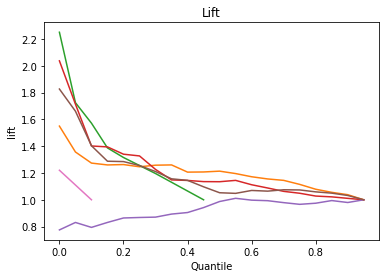

In [96]:
for model in models:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    plt.xlabel("Quantile")
    plt.ylabel("lift")
    plt.title("Lift")

In [65]:
sel_new = pd.read_csv("C:/Users/kamal/DSC GRP PRJ/new_campaign_selection.csv")
ftable3 = pd.DataFrame(sel_new['donorID'].drop_duplicates())
ftable3['donorID'] = ftable3['donorID'].astype(str)
ftable3.head()

,donorID
0,134242
1,126503
2,104392
3,105905
4,120506


In [66]:
ftable3.shape

(26522, 1)

In [67]:
M1 = gifts[gifts['date'] < '2020-01-01'].groupby(['donorID'])['amount'].sum()
M1['donorID'] = M1.index


Ma1 = gifts[gifts['date'] < '2020-01-01'].groupby(['donorID'])['amount'].max()
Ma1['donorID'] = Ma1.index

Mi1 = gifts[gifts['date'] < '2020-01-01'].groupby(['donorID'])['amount'].min()
Mi1['donorID'] = Mi1.index


M2 = gifts[(gifts['date'] < '2020-01-01') & (gifts['date'] > '2017-01-01')].groupby(['donorID'])['amount'].sum()
M2['donorID'] = M2.index

F2= gifts[(gifts['date'] < '2020-01-01') & (gifts['date'] > '2017-01-01')].groupby(['donorID'])['date'].count()
F2['donorID'] = F2.index


M3 = gifts[(gifts['date'] < '2020-01-01') & (gifts['date'] > '2014-01-01')].groupby(['donorID'])['amount'].sum()
M3['donorID'] = M3.index

F3= gifts[(gifts['date'] < '2020-01-01') & (gifts['date'] > '2014-01-01')].groupby(['donorID'])['date'].count()
F3['donorID'] = F3.index


M4 = gifts[(gifts['date'] < '2020-01-01') & (gifts['date'] > '2011-05-18')].groupby(['donorID'])['amount'].sum()
M4['donorID'] = M4.index

F4= gifts[(gifts['date'] < '2020-01-01') & (gifts['date'] > '2011-05-18')].groupby(['donorID'])['date'].count()
F4['donorID'] = F4.index

F1= gifts[gifts['date'] < '2020-01-01'].groupby(['donorID'])['date'].count()
F1['donorID'] = F1.index

NC1= gifts[gifts['date'] < '2020-01-01'].groupby(['donorID'])['NCD'].sum()
NC1['donorID'] = NC1.index

R1= gifts[gifts['date'] < '2020-01-01'].groupby(['donorID']).agg({'date': [np.min,np.max]})
R2 = R1['date']
R2['camp_date'] = '2020-02-01'
R2.camp_date = R2.camp_date.astype('datetime64[ns]')
R2['Recency'] = (R2.camp_date - R2.amax).dt.days
R2['Tenure'] = (R2.amax - R2.amin).dt.days
R2.Recency =  R2.Recency.astype('int')
R2.head()


#Merging this values from gift table for each individual ID's

ftable3 = (ftable3.merge(M1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable3 = (ftable3.merge(F1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable3 = (ftable3.merge(NC1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable3 = (ftable3.merge(R2, left_on = 'donorID', right_on = 'donorID',how = 'left'))

ftable3.drop(['amax','camp_date'],axis=1,inplace=True)

ftable3.rename(columns={'amount': 'Total Donated Amount','date':'No_Donation','NCD' : 'Non-Camp Donations', 'amount_y':'Max Donation'
                       }, inplace=True)

ftable3['Avg_donation'] = ftable3['Total Donated Amount'] / ftable3['No_Donation']
ftable3['ADGBD'] = ftable3['Tenure'] / ftable3['No_Donation']

ftable3 = (ftable3.merge(Ma1, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable3 = (ftable3.merge(Mi1, left_on = 'donorID', right_on = 'donorID',how = 'left'))

ftable3.rename(columns={'amount_x': 'Max Donation','amount_y': 'Min Donation',}, inplace=True)

ftable3 = (ftable3.merge(M2, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable3 = (ftable3.merge(F2, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable3 = (ftable3.merge(M3, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable3 = (ftable3.merge(F3, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable3 = (ftable3.merge(M4, left_on = 'donorID', right_on = 'donorID',how = 'left'))
ftable3 = (ftable3.merge(F4, left_on = 'donorID', right_on = 'donorID',how = 'left'))

ftable3.rename(columns={'amount_x': 'Tot_Donation_3','amount_y': 'Tot_Donation_6', 'amount': 'Tot_Donation_9'}, inplace=True)
ftable3.rename(columns={'date_x': 'Tot_FRQ_3','date_y': 'Tot_FRQ_6', 'date': 'Tot_FRQ_9'}, inplace=True)

ftable3['Avg_donation_3'] = ftable3['Tot_Donation_3'] / ftable3['Tot_FRQ_3']
ftable3['Avg_donation_6'] = ftable3['Tot_Donation_6'] / ftable3['Tot_FRQ_6']
ftable3['Avg_donation_9'] = ftable3['Tot_Donation_9'] / ftable3['Tot_FRQ_9']

ftable3['Total_donated_30'] = 0
ftable3.loc[ftable3['Total Donated Amount'] >= 30, 'Total_donated_30']  = 1

del M1
del F1
del NC1
del R1
del R2

ftable3.head(100) # ftable2 has each customers donation behaviour from before 18th May 2019.

<ipython-input-67-b1b0ccc69694>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R2['camp_date'] = '2020-02-01'
C:\Users\kamal\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-67-b1b0ccc69694>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,amin,Recency,Tenure,Avg_donation,ADGBD,Max Donation,...,Tot_Donation_3,Tot_FRQ_3,Tot_Donation_6,Tot_FRQ_6,Tot_Donation_9,Tot_FRQ_9,Avg_donation_3,Avg_donation_6,Avg_donation_9,Total_donated_30
0,134242,30.0,2,0,2012-03-13,2255.0,626.0,15.0,313.0,20.0,...,NaN,NaN,NaN,NaN,30.0,2,NaN,NaN,15.0,1
1,126503,50.0,1,0,2014-12-28,1861.0,0.0,50.0,0.0,50.0,...,NaN,NaN,50.0,1,50.0,1,NaN,50.0,50.0,1
2,104392,50.0,1,0,2014-12-29,1860.0,0.0,50.0,0.0,50.0,...,NaN,NaN,50.0,1,50.0,1,NaN,50.0,50.0,1
3,105905,210.0,3,1,2016-11-21,64.0,1103.0,70.0,367.666667,100.0,...,155.0,2,210.0,3,210.0,3,77.5,70.0,70.0,1
4,120506,61.89,5,0,2008-09-01,2953.0,1217.0,12.378,243.4,12.5,...,NaN,NaN,NaN,NaN,12.0,1,NaN,NaN,12.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,133355,25.0,4,0,2013-06-02,1035.0,1400.0,6.25,350.0,10.0,...,5.0,1,15.0,3,25.0,4,5.0,5.0,6.25,0
96,115905,166.107,2,0,2008-04-21,502.0,3801.0,83.0535,1900.5,150.0,...,150.0,1,150.0,1,150.0,1,150.0,150.0,150.0,1
97,117502,79.75,3,0,2008-04-08,2825.0,1491.0,26.583333,497.0,50.0,...,NaN,NaN,NaN,NaN,50.0,1,NaN,NaN,50.0,1
98,116338,73.44,5,0,2008-04-09,3312.0,1003.0,14.688,200.6,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [68]:
#We need to merge the donors table with this table to obtain details out for every customer.
# The granularity is by Donor ID wise.
ftable3 = pd.merge(ftable3,donors, left_on = 'donorID', right_on = 'donorID', how = 'left')
ftable3

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,amin,Recency,Tenure,Avg_donation,ADGBD,Max Donation,...,zipcode,province,region,gender,language,dateOfBirth,Missing_Gender,camp1_age,camp2_age,camp3_age
0,134242,30.0,2,0,2012-03-13,2255.0,626.0,15.0,313.0,20.0,...,3580.0,6.0,1.0,0.0,1.0,1966-09-28,0.0,51.0,52.0,53.0
1,126503,50.0,1,0,2014-12-28,1861.0,0.0,50.0,0.0,50.0,...,4250.0,5.0,2.0,0.0,2.0,1949-10-20,0.0,68.0,69.0,70.0
2,104392,50.0,1,0,2014-12-29,1860.0,0.0,50.0,0.0,50.0,...,4820.0,5.0,2.0,1.0,2.0,1974-05-03,0.0,44.0,45.0,45.0
3,105905,210.0,3,1,2016-11-21,64.0,1103.0,70.0,367.666667,100.0,...,8370.0,10.0,1.0,0.0,1.0,1970-09-18,0.0,47.0,48.0,49.0
4,120506,61.89,5,0,2008-09-01,2953.0,1217.0,12.378,243.4,12.5,...,8020.0,10.0,1.0,0.0,1.0,1973-09-19,0.0,44.0,45.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26517,114719,24.79,1,0,2008-04-12,4312.0,0.0,24.79,0.0,24.79,...,8560.0,10.0,1.0,0.0,1.0,1972-05-22,0.0,46.0,47.0,47.0
26518,134824,100.0,1,0,2012-05-13,2820.0,0.0,100.0,0.0,100.0,...,2920.0,0.0,1.0,0.0,1.0,1975-01-31,0.0,43.0,44.0,45.0
26519,143259,40.0,1,0,2016-10-26,1193.0,0.0,40.0,0.0,40.0,...,8430.0,10.0,1.0,0.0,1.0,1995-02-12,0.0,23.0,24.0,24.0
26520,123936,510.36,19,0,2009-07-06,941.0,2921.0,26.861053,153.736842,35.0,...,9880.0,2.0,1.0,0.0,1.0,1977-01-20,0.0,41.0,42.0,43.0


In [69]:
# Adding New Variable Minimum Age of Donation
ftable3['min_age'] = (ftable3.amin - ftable3.dateOfBirth)/np.timedelta64(1, 'Y')

# Removing the Extra Unnecessary Columns
ftable3.drop(['dateOfBirth','amin','camp1_age','camp2_age'],axis=1,inplace=True)
ftable3.rename(columns={'camp3_age': 'camp_age'}, inplace=True)

In [70]:
ftable3['age_group'] = ftable3['camp_age'] // 10 * 10
ftable3.head(100)

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,Total_donated_30,zipcode,province,region,gender,language,Missing_Gender,camp_age,min_age,age_group
0,134242,30.0,2,0,2255.0,626.0,15.0,313.0,20.0,10.0,...,1,3580.0,6.0,1.0,0.0,1.0,0.0,53.0,45.457470,50.0
1,126503,50.0,1,0,1861.0,0.0,50.0,0.0,50.0,50.0,...,1,4250.0,5.0,2.0,0.0,2.0,0.0,70.0,65.189566,70.0
2,104392,50.0,1,0,1860.0,0.0,50.0,0.0,50.0,50.0,...,1,4820.0,5.0,2.0,1.0,2.0,0.0,45.0,40.657919,40.0
3,105905,210.0,3,1,64.0,1103.0,70.0,367.666667,100.0,55.0,...,1,8370.0,10.0,1.0,0.0,1.0,0.0,49.0,46.177540,40.0
4,120506,61.89,5,0,2953.0,1217.0,12.378,243.4,12.5,12.0,...,1,8020.0,10.0,1.0,0.0,1.0,0.0,46.0,34.952121,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,133355,25.0,4,0,1035.0,1400.0,6.25,350.0,10.0,5.0,...,0,3680.0,6.0,1.0,0.0,1.0,0.0,34.0,28.318172,30.0
96,115905,166.107,2,0,502.0,3801.0,83.0535,1900.5,150.0,16.107,...,1,2140.0,0.0,1.0,1.0,1.0,0.0,68.0,56.915611,60.0
97,117502,79.75,3,0,2825.0,1491.0,26.583333,497.0,50.0,4.96,...,1,8490.0,10.0,1.0,0.0,1.0,0.0,57.0,45.230224,50.0
98,116338,73.44,5,0,3312.0,1003.0,14.688,200.6,26.0,7.44,...,1,8500.0,10.0,1.0,1.0,1.0,0.0,50.0,38.453904,50.0


In [71]:
ftable3.isnull().sum()

donorID                     0
Total Donated Amount        3
No_Donation                 3
Non-Camp Donations          3
Recency                     3
Tenure                      3
Avg_donation                3
ADGBD                       3
Max Donation                3
Min Donation                3
Tot_Donation_3          20529
Tot_FRQ_3               20529
Tot_Donation_6          13835
Tot_FRQ_6               13835
Tot_Donation_9           8056
Tot_FRQ_9                8056
Avg_donation_3          20529
Avg_donation_6          13835
Avg_donation_9           8056
Total_donated_30            0
zipcode                     2
province                    2
region                      2
gender                      2
language                    2
Missing_Gender              2
camp_age                    2
min_age                     5
age_group                   2
dtype: int64

In [72]:
# Dropping the rows where there are missing values 
ftable3 = ftable3.drop(ftable3[ftable3['min_age'].isnull()].index)
#Have to Decide whether to remove them or keep their values as a default/average value 

In [73]:
ftable3.Tot_Donation_3 = ftable3.Tot_Donation_3.fillna(0)
ftable3.Tot_FRQ_3 = ftable3.Tot_FRQ_3.fillna(0)
ftable3.Tot_Donation_6 = ftable3.Tot_Donation_6.fillna(0)
ftable3.Tot_FRQ_6 = ftable3.Tot_FRQ_6.fillna(0)
ftable3.Tot_Donation_9 = ftable3.Tot_Donation_9.fillna(0)
ftable3.Tot_FRQ_9 = ftable3.Tot_FRQ_9.fillna(0)
ftable3.Avg_donation_3 = ftable3.Avg_donation_3.fillna(0)
ftable3.Avg_donation_6 = ftable3.Avg_donation_6.fillna(0)
ftable3.Avg_donation_9 = ftable3.Avg_donation_9.fillna(0)

In [74]:
#Changing the Column Types
ftable3['Avg_donation'] = ftable3['Avg_donation'].astype('float64')
ftable3['Total Donated Amount'] = ftable3['Total Donated Amount'].astype('float64')
ftable3.loc[:, ~ftable3.columns.isin(['Avg_donation', 'Total Donated Amount'])] = ftable3.loc[:, ~ftable3.columns.isin(['Avg_donation', 'Total Donated Amount'])].astype(int)

ftable3.head(100)

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,Total_donated_30,zipcode,province,region,gender,language,Missing_Gender,camp_age,min_age,age_group
0,134242,30.000,2,0,2255,626,15.000000,313,20,10,...,1,3580,6,1,0,1,0,53,45,50
1,126503,50.000,1,0,1861,0,50.000000,0,50,50,...,1,4250,5,2,0,2,0,70,65,70
2,104392,50.000,1,0,1860,0,50.000000,0,50,50,...,1,4820,5,2,1,2,0,45,40,40
3,105905,210.000,3,1,64,1103,70.000000,367,100,55,...,1,8370,10,1,0,1,0,49,46,40
4,120506,61.890,5,0,2953,1217,12.378000,243,12,12,...,1,8020,10,1,0,1,0,46,34,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,133355,25.000,4,0,1035,1400,6.250000,350,10,5,...,0,3680,6,1,0,1,0,34,28,30
96,115905,166.107,2,0,502,3801,83.053500,1900,150,16,...,1,2140,0,1,1,1,0,68,56,60
97,117502,79.750,3,0,2825,1491,26.583333,497,50,4,...,1,8490,10,1,0,1,0,57,45,50
98,116338,73.440,5,0,3312,1003,14.688000,200,26,7,...,1,8500,10,1,1,1,0,50,38,50


In [76]:
#Checking the Performance of the Models
DataFrame(performance)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Accuracy,0.963226,0.985883,0.983855,0.984830,0.985922,0.912530,0.985649
AUC,0.541700,0.667601,0.635201,0.657182,0.452589,0.607831,0.528418


In [78]:
performances = {}

for model in models:
    predictions   = models[model].predict(ftable3[features])
    print(model, predictions.sum())

tree 1336
logistic 126
randomForest 119
boostedTree 354
svm 0
neuralNet 3574


C:\Users\kamal\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


neighbors 112


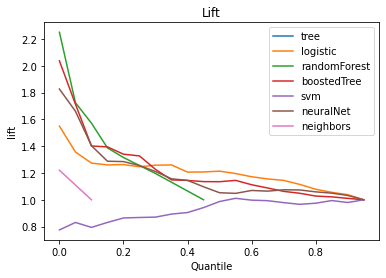

In [104]:
#Plotting the Lift of the Models
for model in models:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    plt.legend(models)
    plt.xlabel("Quantile")
    plt.ylabel("lift")
    plt.title("Lift")

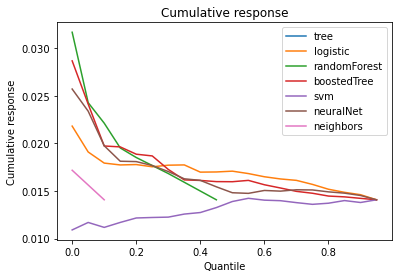

In [105]:
#lifts     = {}
#responses = {}
#gains     = {}

#Plotting the Response of the Models
for model in models:
    plt.plot(responses[model]["Quantile"], responses[model]["Cumulative response"])
    plt.legend(models)
    plt.xlabel("Quantile")
    plt.ylabel("Cumulative response")
    plt.title("Cumulative response")

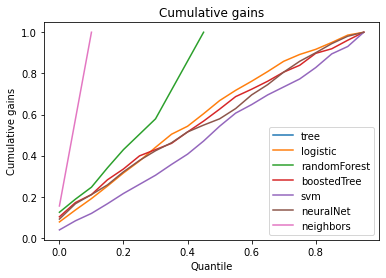

In [106]:
#Plotting the Gains of the Models
for model in models:
    plt.plot(gains[model]["Quantile"], gains[model]["Cumulative gains"])
    plt.legend(models)
    plt.xlabel("Quantile")
    plt.ylabel("Cumulative gains")
    plt.title("Cumulative gains")

AUC Score for tree 0.54
AUC Score for logistic 0.67
AUC Score for randomForest 0.64
AUC Score for boostedTree 0.66
AUC Score for svm 0.45
AUC Score for neuralNet 0.61


C:\Users\kamal\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


AUC Score for neighbors 0.53


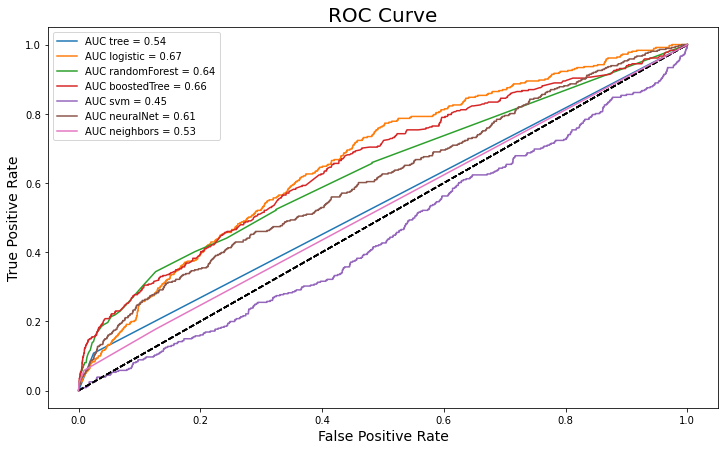

In [84]:
#Plotting the ROC Curve of the Models

from sklearn.metrics        import roc_auc_score, roc_curve



plt.figure(figsize=(12, 7))

for model in models:

    x =  models[model].predict_proba(ftable2[features])[:, 1]

    y = roc_auc_score(ftable2[target], x)

    fpr, tpr, thresholds = roc_curve(ftable2[target], x)

    print('AUC Score for', model, round(y,2))

    plt.plot([0, 1], [0, 1], 'k--')

    plt.plot(fpr, tpr, label=f'AUC {model} = {y:.2f}')

    plt.title('ROC Curve', size=20)

    plt.xlabel('False Positive Rate', size=14)

    plt.ylabel('True Positive Rate', size=14)

    plt.legend()
    
    # reference https://towardsdatascience.com/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time-fb2304c83a7f

# Scoring and setting the customers who will come for the third campaign

In [107]:
ftable3['proba_donation'] = pd.DataFrame(neuralNet.predict_proba(ftable3[selectedFeatures].values)[:,1])
ftable3 = ftable3.sort_values('proba_donation',ascending=False)
ftable3

C:\Users\kamal\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,zipcode,province,region,gender,language,Missing_Gender,camp_age,min_age,age_group,proba_donation
23875,141589,30.00,1,0,1786,0,30.000000,0,30,30,...,9150,2,1,0,1,0,57,52,50,1.0
23049,126462,170.00,5,2,3191,716,34.000000,143,50,30,...,1910,3,1,0,1,0,65,54,60,1.0
5645,137344,200.00,4,0,982,1100,50.000000,275,50,50,...,8000,10,1,1,1,0,54,49,50,1.0
10178,123160,111.00,3,0,303,3616,37.000000,1205,41,30,...,9620,2,1,1,1,0,51,40,50,1.0
24960,109863,19.83,2,0,4787,86,9.915000,43,12,7,...,3040,3,1,0,1,0,48,35,40,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26517,114719,24.79,1,0,4312,0,24.790000,0,24,24,...,8560,10,1,0,1,0,47,35,40,NaN
26518,134824,100.00,1,0,2820,0,100.000000,0,100,100,...,2920,0,1,0,1,0,45,37,40,NaN
26519,143259,40.00,1,0,1193,0,40.000000,0,40,40,...,8430,10,1,0,1,0,24,21,20,NaN
26520,123936,510.36,19,0,941,2921,26.861053,153,35,20,...,9880,2,1,0,1,0,43,32,40,NaN


In [108]:
ftable3['predict'] = neuralNet.predict(ftable3[selectedFeatures])

In [113]:
donor_list = ftable3[['donorID','proba_donation']]

In [114]:
donor_list.to_csv(r'./donor_list.csv')  # Customer Data Set with the probability Values 

,donorID,campaignID,amount,date,NCD
0,100001,NCD,12.39,2004-03-23,1
1,100001,1577,12.39,2007-10-11,0
2,100001,1634,6.69,2007-12-28,0
3,100001,1778,24.79,2008-06-14,0
4,100001,1808,7.44,2008-07-09,0
...,...,...,...,...,...
216589,265584,6169,300.00,2018-09-23,0
216590,281770,6169,30.00,2018-09-08,0
216591,317880,6169,157.50,2018-09-12,0
216592,480980,6169,36.00,2018-09-12,0


In [169]:
don1 = pd.DataFrame(gifts.groupby(['campaignID'])['amount'].sum())

In [170]:
don1['campaignID'] = don1.index

In [208]:
avg_don_amount = don1[don1['campaignID'] == '7224']['amount']/361

In [175]:
avg_don_amount

campaignID
7244    51.567867
Name: amount, dtype: float64

In [185]:
ftable3[(ftable3['predict'] == 1) & (ftable3['Total Donated Amount'] > 30)]

,donorID,Total Donated Amount,No_Donation,Non-Camp Donations,Recency,Tenure,Avg_donation,ADGBD,Max Donation,Min Donation,...,province,region,gender,language,Missing_Gender,camp_age,min_age,age_group,proba_donation,predict
5645,137344,200.00,4,0,982,1100,50.000000,275,50,50,...,10,1,1,1,0,54,49,50,1.000000e+00,1
4512,144648,847.06,30,2,120,6926,28.235333,230,40,24,...,2,1,1,1,0,62,43,60,1.000000e+00,1
736,102791,1067.29,36,0,50,5140,29.646944,142,39,8,...,10,1,0,1,0,93,78,90,9.999997e-01,1
14525,103345,320.46,27,0,365,4906,11.868889,181,15,10,...,2,1,1,1,0,31,16,30,9.999996e-01,1
2197,109609,155.57,41,2,73,4873,3.794390,118,13,2,...,2,1,0,1,0,54,40,50,9.999984e-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18029,114208,170.00,4,0,1207,1605,42.500000,401,50,40,...,3,1,0,1,0,73,65,70,5.892437e-27,1
12167,100490,271.39,11,0,1255,2802,24.671818,254,39,10,...,3,1,1,1,0,36,25,30,3.989977e-27,1
16582,112748,124.79,4,0,586,4026,31.197500,1006,40,24,...,0,1,0,1,0,74,62,70,2.014951e-28,1
23111,116954,289.58,9,0,1618,2692,32.175556,299,50,24,...,10,1,0,1,0,57,45,50,6.245165e-29,1


In [189]:
# Renaming the variables for donor profiling
dictionary = {0 : "M" , 1 : "F" }
ftable3 = ftable3.replace({"gender": dictionary})

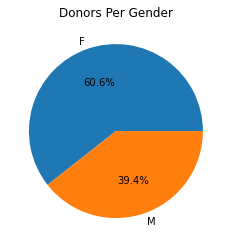

In [202]:
#Number of account orders per region
# Calculate the population per continent
gender = ftable3[(ftable3['predict'] == 1)].groupby('gender')['donorID'].agg(['count'])
gender = gender.sort_values(by='count', ascending=False)

# Bar plot
fig, ax = plt.subplots()
ax.pie(gender['count'],labels = gender.index , autopct='%1.1f%%')
ax.set_title('Donors Per Gender')
plt.show()

In [207]:
ftable3.to_csv(r'./final_table.csv') # Exporting the CSV to make better visualizations for the presentation